In [2]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
np.set_printoptions(precision=4)

2024-05-16 11:06:16.906539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 11:06:16.906603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 11:06:17.165501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 11:06:17.850911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 11:06:23.236087: W tensorflow/compiler/tf2

In [11]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [12]:
#将每个字符编码为一个整数
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
#设置char_level=True，以得到字符级别的编码，而不是默认的单词级别的编码
tokenizer.fit_on_texts([shakespeare_text])

In [13]:
tokenizer.texts_to_sequences(["Fuck"])

[[20, 14, 19, 25]]

In [14]:
tokenizer.sequences_to_texts([[20, 14, 19, 25]])

['f u c k']

## 将序列数据集切分成多个窗口

In [15]:
#对完整文本做编码，将每个字符都用 ID 来表示（减 1 使 ID 从 0 到 38，而不是 1 到 39）
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

dataset_size=len(encoded)

In [16]:
#将前 90% 的文本作为训练集（剩下的作为验证集和测试集）
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])


In [17]:
#调用window()方法创建一个短文本窗口的数据集
#RNN 学不到任何长度超过n_steps的规律，所以n_steps不要太短
n_steps = 100
window_length = n_steps + 1 # target = input 向前移动 1 个字符
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

#为了获得可能的最大训练集,设定shift=1，第一个窗口包含字符 0 到 100，第二个窗口包含字符 1 到 101
#为了确保所有窗口是准确的 101 个字符长度，设置drop_remainder=True

In [20]:
#batch(window_length)对于每个固定长度窗口，得到一个独立的张量，flat_map 再打平这些张量，组成数据集
#shuffle 打散这些窗口
#对窗口做批次，分割输入（前 100 个字符）和目标（最后一个字符）

dataset = dataset.flat_map(lambda window: window.batch(window_length))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

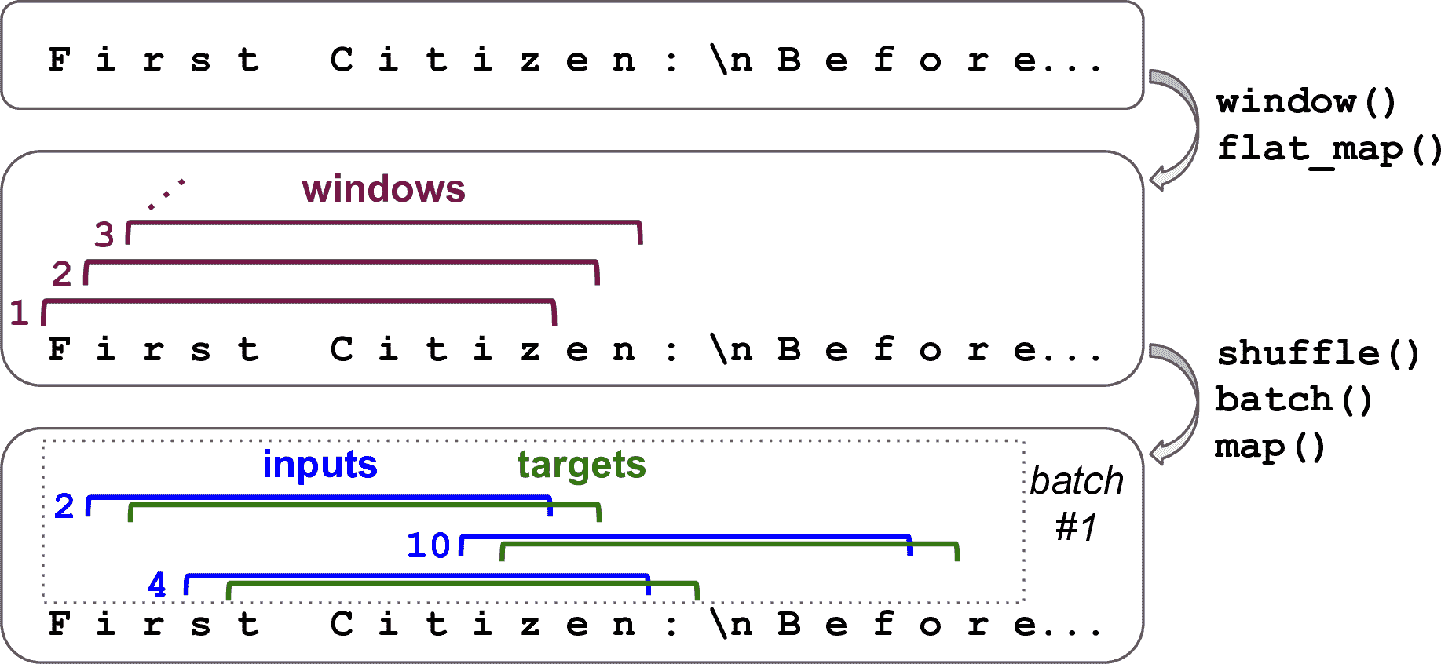

In [21]:
from IPython import display
display.Image("https://hands1ml.apachecn.org/img/847ef99a515939c6266e9a184ac7e061.png",width=640)

In [22]:
#独热编码输入字符，再预提取
max_id=39
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1) 


## 搭建并训练 Char-RNN 模型

In [ ]:
#每个单元对输入（dropout）和隐藏态（recurrent_dropout）的丢弃率是 20%
#输出层是一个时间分布的紧密层，有 39 个单元（max_id）

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0, recurrent_dropout=0),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0, recurrent_dropout=0),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

callback=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
history = model.fit(dataset, epochs=20,callbacks=callback)

Epoch 1/20
  31367/Unknown - 2824s 90ms/step - loss: 0.9717 - accuracy: 0.7279WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
31368/31368 [==============================] - 2824s 90ms/step - loss: 0.9717 - accuracy: 0.7279
Epoch 2/20
31368/31368 [==============================] - 2898s 92ms/step - loss: 0.9483 - accuracy: 0.7297
Epoch 3/20
31368/31368 [==============================] - 2772s 88ms/step - loss: 1.0063 - accuracy: 0.7051
Epoch 4/20
31368/31368 [==============================] - 2810s 90ms/step - loss: 1.0486 - accuracy: 0.6872
Epoch 5/20
31368/31368 [==============================] - 2777s 88ms/step - loss: 1.0891 - accuracy: 0.6719
Epoch 6/20
29757/31368 [===========================>..] - ETA: 2:23 - loss: 1.1102 - accuracy: 0.6630

# 用编码器-解码器做机器翻译


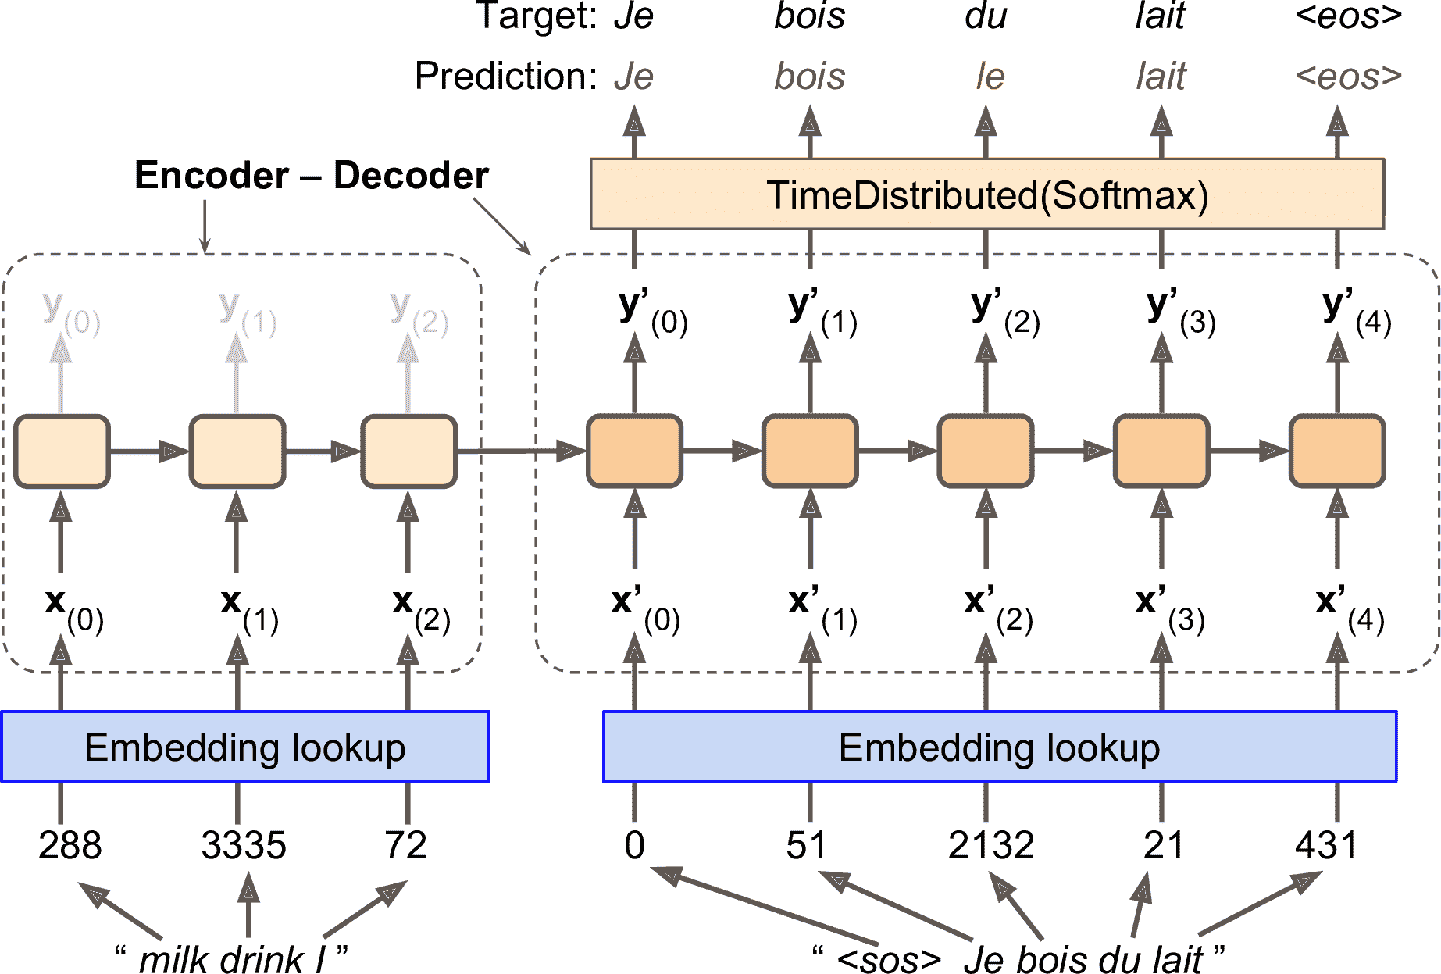

In [23]:
#训练时
from IPython import display
display.Image("https://hands1ml.apachecn.org/img/aef8aa3fde805533d8461794f1548f17.png",width=640)

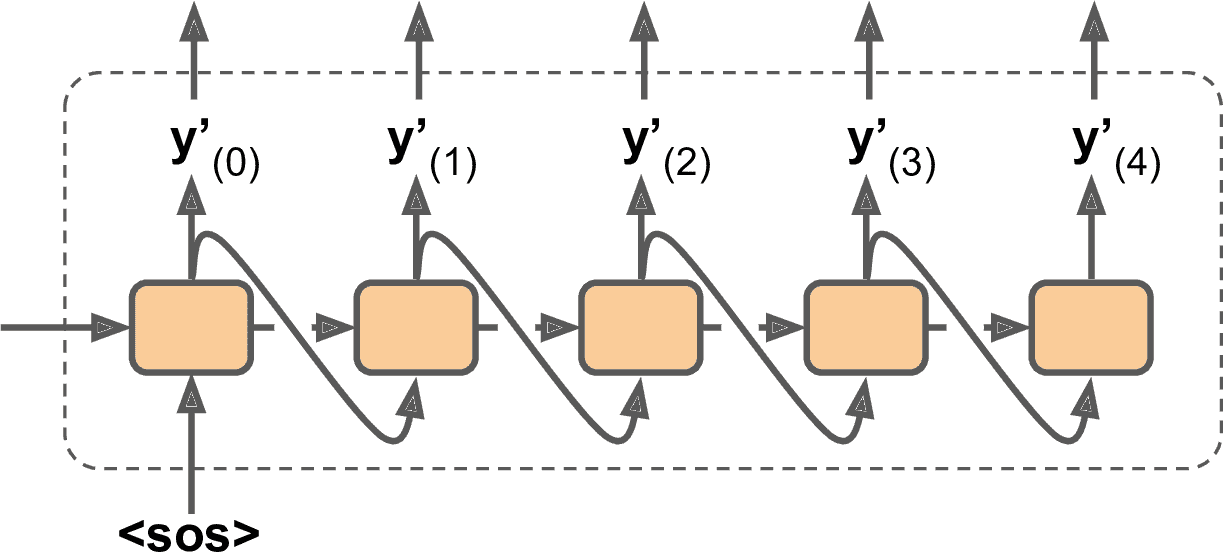

In [43]:
#推断时,没有目标语句输入进解码器。只是输入解码器前一步的输出，另外需要一个嵌入查找表，图中没有展示
display.Image("https://hands1ml.apachecn.org/img/1e702f782691c1e3f0d0a177fb02d497.png",width=640)


In [7]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text(encoding='utf-8')

In [8]:
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [9]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])
#西语格式为['startofseq Qué aburrimiento! endofseq',
#          'startofseq Adoro el deporte. endofseq',...]

In [6]:
text_vec_layer_en.get_vocabulary()[:10]
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [10]:
X_train = tf.constant(sentences_en[:100_000]) #:100_000==:100000
X_valid = tf.constant(sentences_en[100_000:]) #一共118964句子，最后18964句为验证集

#解码器数据是sos开头的西语单词
#解码器标签是eos结尾的西语，单词转换为int id
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

2024-05-16 11:07:31.098700: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [12]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

#定义编码解码器的embedding lookup

In [12]:
#定义编码解码器RNN

encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [13]:
#定义解码输出
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")#是否可以考虑做采样softmax
Y_proba = output_layer(decoder_outputs)

In [14]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10


2024-05-14 18:57:19.360326: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2024-05-14 18:57:27.582974: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-14 18:57:30.345568: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9a2c032ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 18:57

3125/3125 [==============================] - 159s 45ms/step - loss: 2.9021 - accuracy: 0.4294 - val_loss: 2.1538 - val_accuracy: 0.5263
Epoch 2/10
3125/3125 [==============================] - 129s 41ms/step - loss: 1.8296 - accuracy: 0.5773 - val_loss: 1.6377 - val_accuracy: 0.6133
Epoch 3/10
3125/3125 [==============================] - 131s 42ms/step - loss: 1.4159 - accuracy: 0.6518 - val_loss: 1.4149 - val_accuracy: 0.6566
Epoch 4/10
3125/3125 [==============================] - 130s 42ms/step - loss: 1.1841 - accuracy: 0.6985 - val_loss: 1.3240 - val_accuracy: 0.6747
Epoch 5/10
3125/3125 [==============================] - 130s 42ms/step - loss: 1.0196 - accuracy: 0.7319 - val_loss: 1.2842 - val_accuracy: 0.6828
Epoch 6/10
3125/3125 [==============================] - 132s 42ms/step - loss: 0.8858 - accuracy: 0.7604 - val_loss: 1.2774 - val_accuracy: 0.6859
Epoch 7/10
3125/3125 [==============================] - 128s 41ms/step - loss: 0.7723 - accuracy: 0.7863 - val_loss: 1.2953 - val

In [18]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip() #去除首尾空格

translate("I like soccer")

W0000 00:00:1715838501.060257      89 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3070 Ti" frequency: 1770 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 5644484608 bandwidth: 608064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 39ms/step


'me gusta el fútbol'

## 双向 RNN


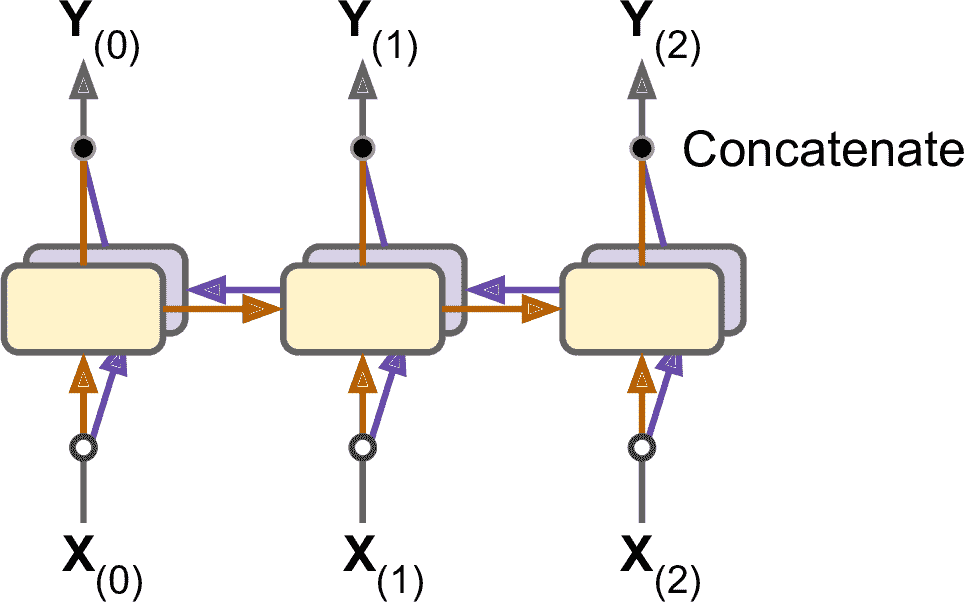

In [25]:
display.Image("https://hands1ml.apachecn.org/img/498e45d619e08c8fc7acff449bfb27de.png",width=512)

In [13]:
#在keras.layers.Bidirectional层中包一个循环层,双向GRU
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)


In [14]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10


2024-05-16 11:08:16.139352: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2024-05-16 11:08:24.759962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-16 11:08:27.477565: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcb6cbad550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 11:08

3125/3125 [==============================] - 198s 57ms/step - loss: 2.7629 - accuracy: 0.4507 - val_loss: 1.9913 - val_accuracy: 0.5530
Epoch 2/10
3125/3125 [==============================] - 163s 52ms/step - loss: 1.6924 - accuracy: 0.6033 - val_loss: 1.5409 - val_accuracy: 0.6309
Epoch 3/10
3125/3125 [==============================] - 165s 53ms/step - loss: 1.3327 - accuracy: 0.6699 - val_loss: 1.3616 - val_accuracy: 0.6669
Epoch 4/10
3125/3125 [==============================] - 161s 52ms/step - loss: 1.1340 - accuracy: 0.7093 - val_loss: 1.2852 - val_accuracy: 0.6815
Epoch 5/10
3125/3125 [==============================] - 163s 52ms/step - loss: 0.9901 - accuracy: 0.7391 - val_loss: 1.2536 - val_accuracy: 0.6894
Epoch 6/10
3125/3125 [==============================] - 161s 52ms/step - loss: 0.8748 - accuracy: 0.7633 - val_loss: 1.2539 - val_accuracy: 0.6907
Epoch 7/10
3125/3125 [==============================] - 159s 51ms/step - loss: 0.7768 - accuracy: 0.7855 - val_loss: 1.2736 - val

## 集束搜索



它跟踪k个最大概率的句子列表，在每个解码器步骤延长一个词，然后再关注其中k个最大概率的句子
参数k被称为集束宽度。

使用宽度为 3 的集束搜索，用模型来翻译句子Comment vas-tu?。在第一个解码步骤，模型会输出每个可能词的估计概率。假设前 3 个词的估计概率是How（估计概率是 75%）、What（3%）、You（1%）。

然后，创建三个模型的复制，预测每个句子的下一个词。第一个模型会预测How后面的词，假设结果是 36% 为will、32% 为are、16% 为do，等等。第二个模型会预测What后面的词：50% 为are，等等。假设词典有 10000 个词，每个模型会输出 10000 个概率。

然后，计算 30000 个含有两个词的句子的概率。将条件概率相乘。例如，How will的概率是75% × 36% = 27%。计算完 30000 个概率之后，只保留概率最大的 3 个。假设是How will（27%）、How are（24%）、How do（12%）。现在How will的概率最大，但How are并没有被删掉。

接着，重复同样的过程：用三个模型预测这三个句子的接下来的词，再计算 30000 个含有三个词的句子的概率。假设前三名是How are you（10%）、How do you（8%）、How will you（2%）。再下一步的前三名是How do you do（7%）、How are you <eos>（6%）、How are you doing（3%）。注意，How will被淘汰了

# 注意力机制

In [15]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))
#to feed all the encoder's outputs to the Attention layers，must add return_sequences=True to the encoder

encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [16]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [17]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10


W0000 00:00:1715830554.629560      89 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3070 Ti" frequency: 1770 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 5644484608 bandwidth: 608064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3124/3125 [============================>.] - ETA: 0s - loss: 2.2539 - accuracy: 0.5384

W0000 00:00:1715830724.612577      89 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3070 Ti" frequency: 1770 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 5644484608 bandwidth: 608064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3125/3125 [==============================] - 191s 58ms/step - loss: 2.2537 - accuracy: 0.5384 - val_loss: 1.5439 - val_accuracy: 0.6454
Epoch 2/10
3125/3125 [==============================] - 164s 53ms/step - loss: 1.3817 - accuracy: 0.6748 - val_loss: 1.3430 - val_accuracy: 0.6823
Epoch 3/10
3125/3125 [==============================] - 164s 52ms/step - loss: 1.1976 - accuracy: 0.7092 - val_loss: 1.2598 - val_accuracy: 0.6996
Epoch 4/10
3125/3125 [==============================] - 164s 52ms/step - loss: 1.0772 - accuracy: 0.7321 - val_loss: 1.2273 - val_accuracy: 0.7079
Epoch 5/10
3125/3125 [==============================] - 164s 52ms/step - loss: 0.9817 - accuracy: 0.7512 - val_loss: 1.2204 - val_accuracy: 0.7105
Epoch 6/10
3125/3125 [==============================] - 164s 52ms/step - loss: 0.9008 - accuracy: 0.7675 - val_loss: 1.2307 - val_accuracy: 0.7103
Epoch 7/10
3125/3125 [==============================] - 164s 52ms/step - loss: 0.8337 - accuracy: 0.7813 - val_loss: 1.2436 - val

In [19]:
 translate("I like soccer and also going to the beach")


1/1 [==============================] - 0s 39ms/step


'me gustan el fútbol y también ir a la playa'